In [1]:
import matplotlib.pyplot as plt
import numpy as np
import librosa as rs
import librosa.display as rd
from tqdm import tqdm
import pandas as pd
import librosa.display
import IPython.display as ipd
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split , KFold ,  cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression



### Loading Data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('val.csv')

train_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 4861 entries, 0 to 4860
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Name     4861 non-null   str  
 1   ClassId  4861 non-null   int64
 2   Class    4861 non-null   str  
dtypes: int64(1), str(2)
memory usage: 114.1 KB


### Exploratory Data Analysis

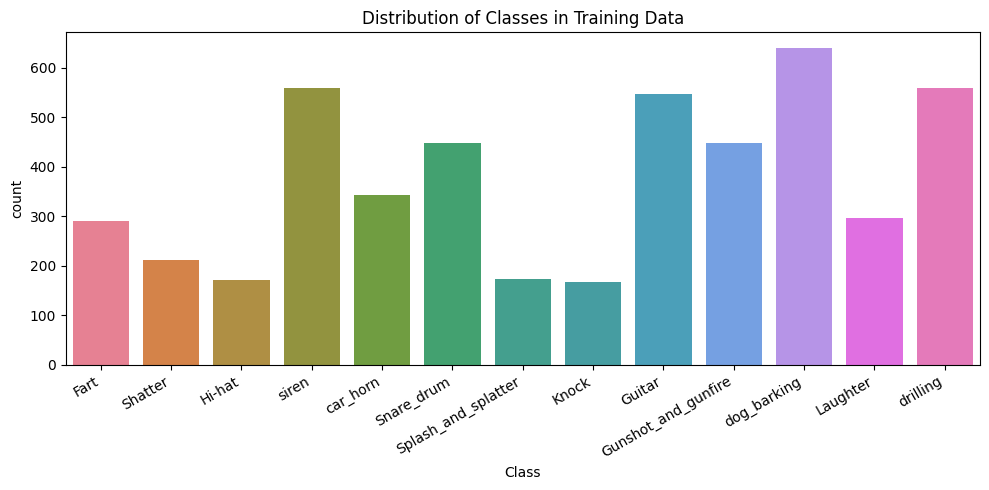

In [3]:
figure = plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Class', hue='Class', data=train_df)
plt.title('Distribution of Classes in Training Data')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

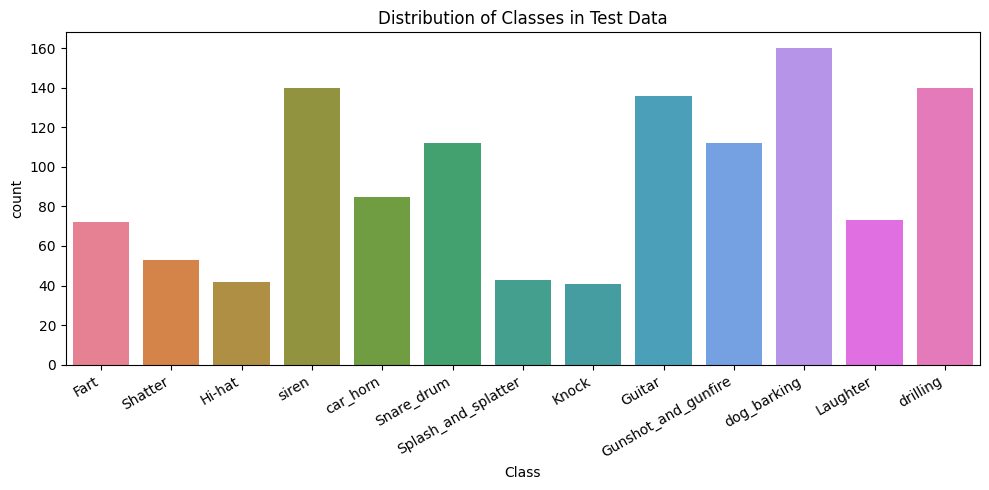

In [4]:
figure = plt.figure(figsize=(10, 5))
ax = sns.countplot(x='Class', hue='Class', data=test_df)
plt.title('Distribution of Classes in Test Data')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [23]:
min_count = train_df['Class'].value_counts().min()
min_count_test = test_df['Class'].value_counts().min()
new_train_df = train_df.groupby('Class', group_keys=False).apply(
    lambda x: x.sample(n=min_count, random_state=42)
).reset_index(drop=True)

new_test_df = test_df.groupby('Class', group_keys=False).apply(
    lambda x: x.sample(n=min_count_test, random_state=42)
).reset_index(drop=True)

new_train_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2184 entries, 0 to 2183
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Name     2184 non-null   str  
 1   ClassId  2184 non-null   int64
dtypes: int64(1), str(1)
memory usage: 34.3 KB


In [6]:
one = 0
two = 0
three = 0
four = 0

for i in tqdm(range(train_df.shape[0])):
        try:
            file_name = f'train/{train_df["Name"][i]}'
            data, sr = librosa.load(file_name) 
            length = round(len(data)/ sr)
            # print(length)
            if length > 1 and length <=2:
                  one+=1
            elif length > 2 and  length <=3:
                  two +=1
            elif length > 3 and length <=4:
                  three += 1
            elif length > 4:
                  four += 1
        except:
              pass
        
print(f'one : {one} \n two: {two}, \n three: {three} \n four: {four}\n')

 39%|███▉      | 1887/4861 [00:09<00:10, 270.55it/s]C:\Users\gamin\AppData\Local\Temp\ipykernel_18836\2553243558.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sr = librosa.load(file_name)
100%|██████████| 4861/4861 [00:24<00:00, 195.86it/s]

one : 1225 
 two: 654, 
 three: 1824 
 four: 0



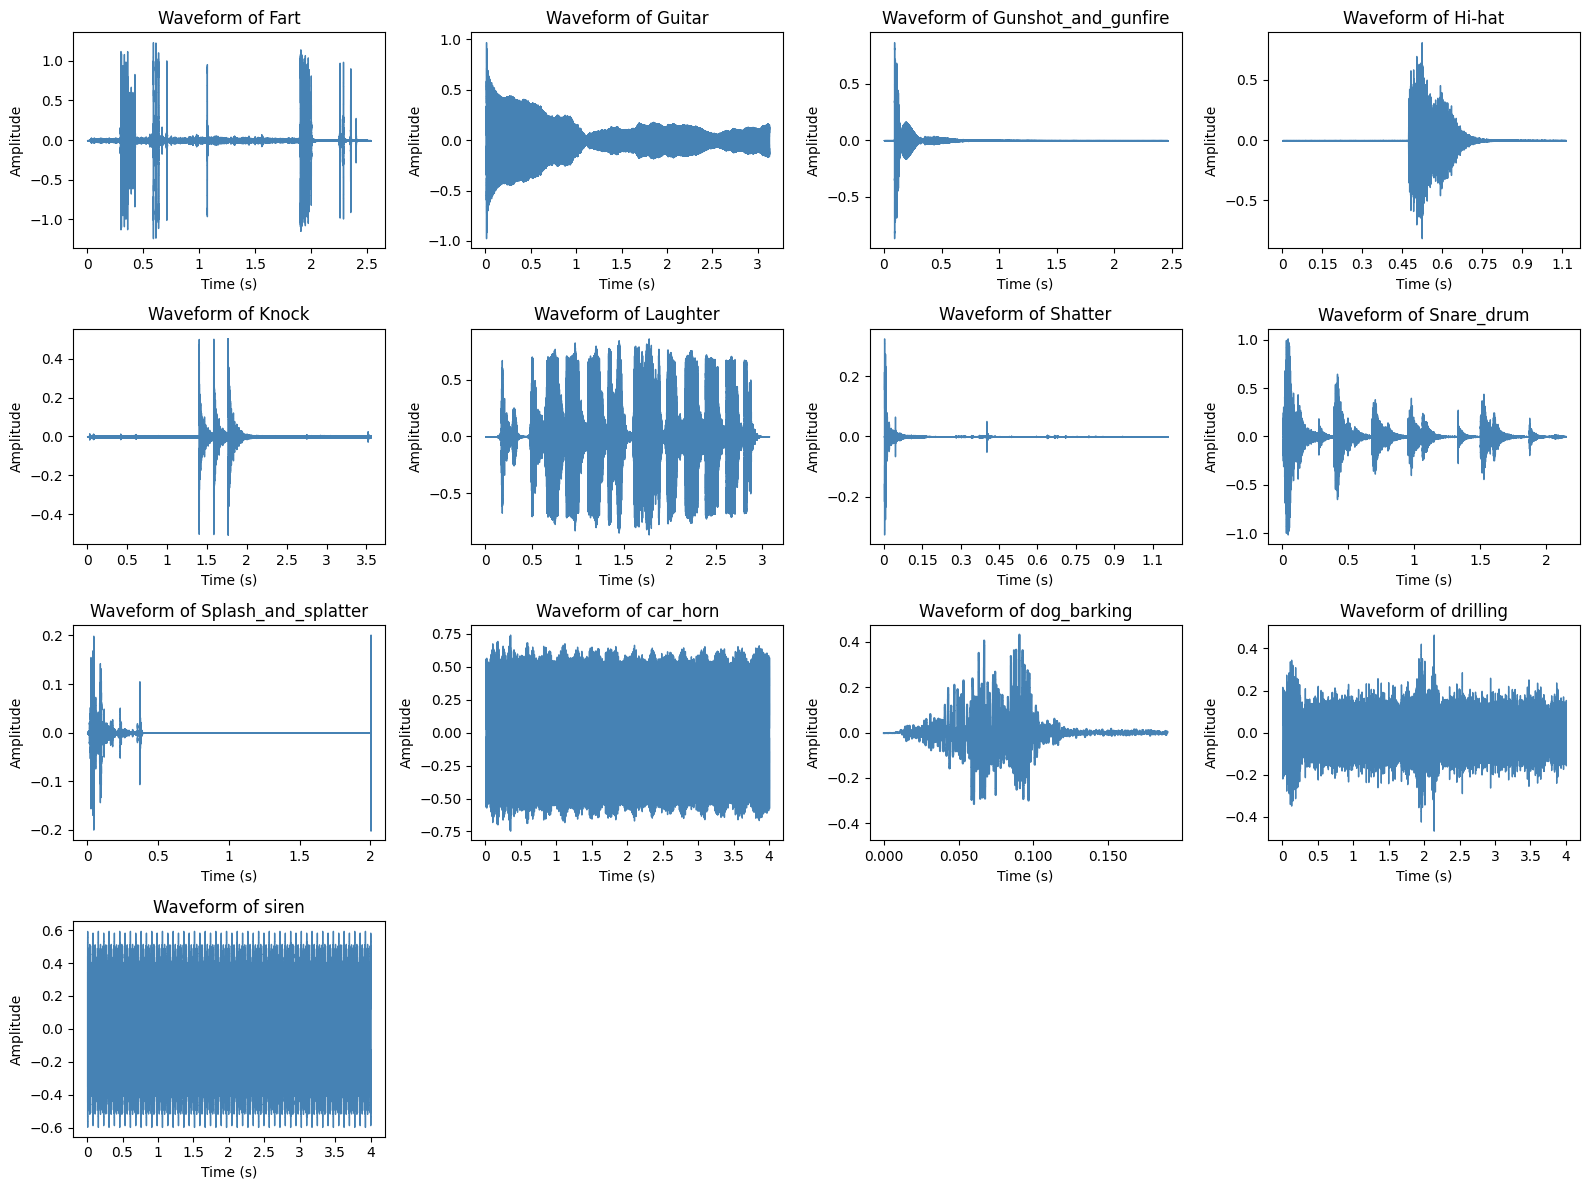

In [5]:
one_per_class = train_df.groupby('Class')['Name'].sample(n=1, random_state=42)

fig, axes = plt.subplots(4,4, figsize=(16,12))
axes = axes.flatten()

for i, name in enumerate(one_per_class):
    file_path = f'train/{name}'
    audio, sr = rs.load(file_path)
    rd.waveshow(audio, sr=sr, ax=axes[i], color='steelblue')
    class_label = train_df[train_df['Name'] == name]['Class'].iloc[0]
    axes[i].set_title(f'Waveform of {class_label}')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Amplitude')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

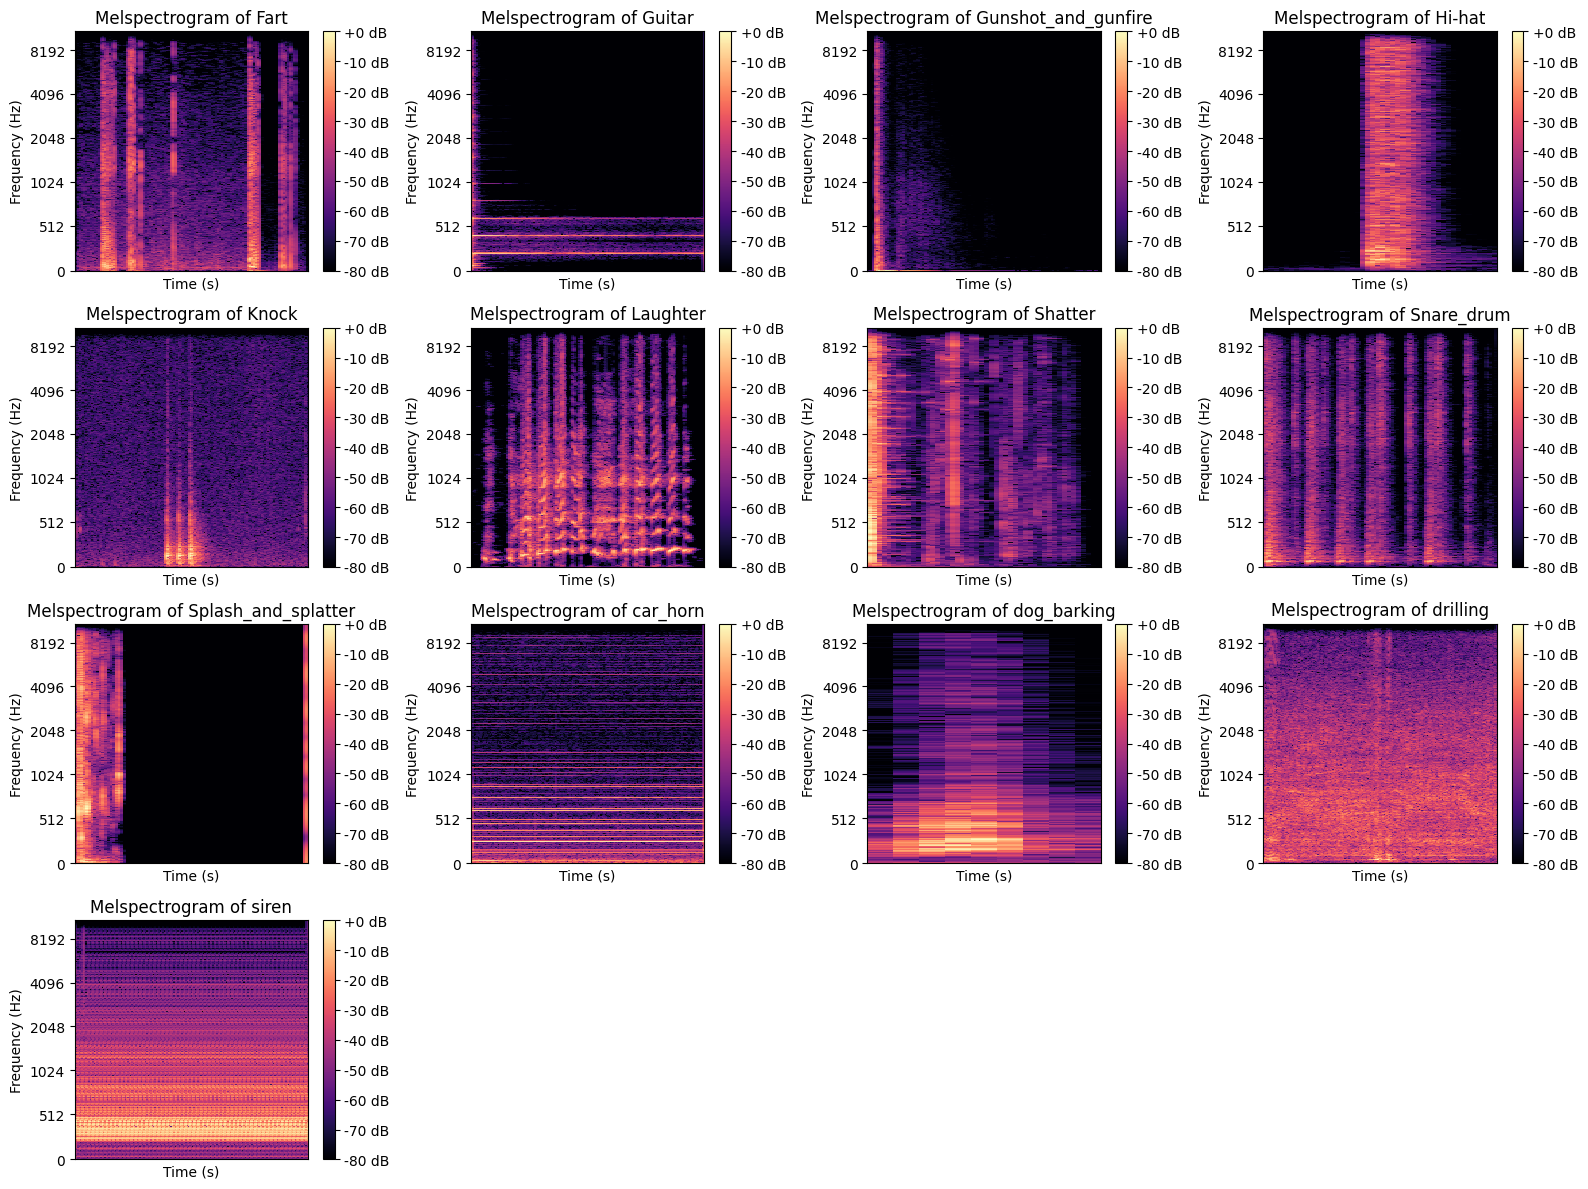

In [6]:
one_per_class = train_df.groupby('Class')['Name'].sample(n=1, random_state=42)

fig, axes = plt.subplots(4,4, figsize=(16,12))
axes = axes.flatten()

for i, name in enumerate(one_per_class):
    file_path = f'train/{name}'
    audio, sr = rs.load(file_path)
    D = rs.amplitude_to_db(np.abs(rs.stft(audio)), ref=np.max)
    img = rs.display.specshow(D, y_axis='mel', ax=axes[i])
    plt.colorbar(img, ax=axes[i], format='%+2.0f dB')
    class_label = train_df[train_df['Name'] == name]['Class'].iloc[0]
    axes[i].set_title(f'Melspectrogram of {class_label}')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Frequency (Hz)')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

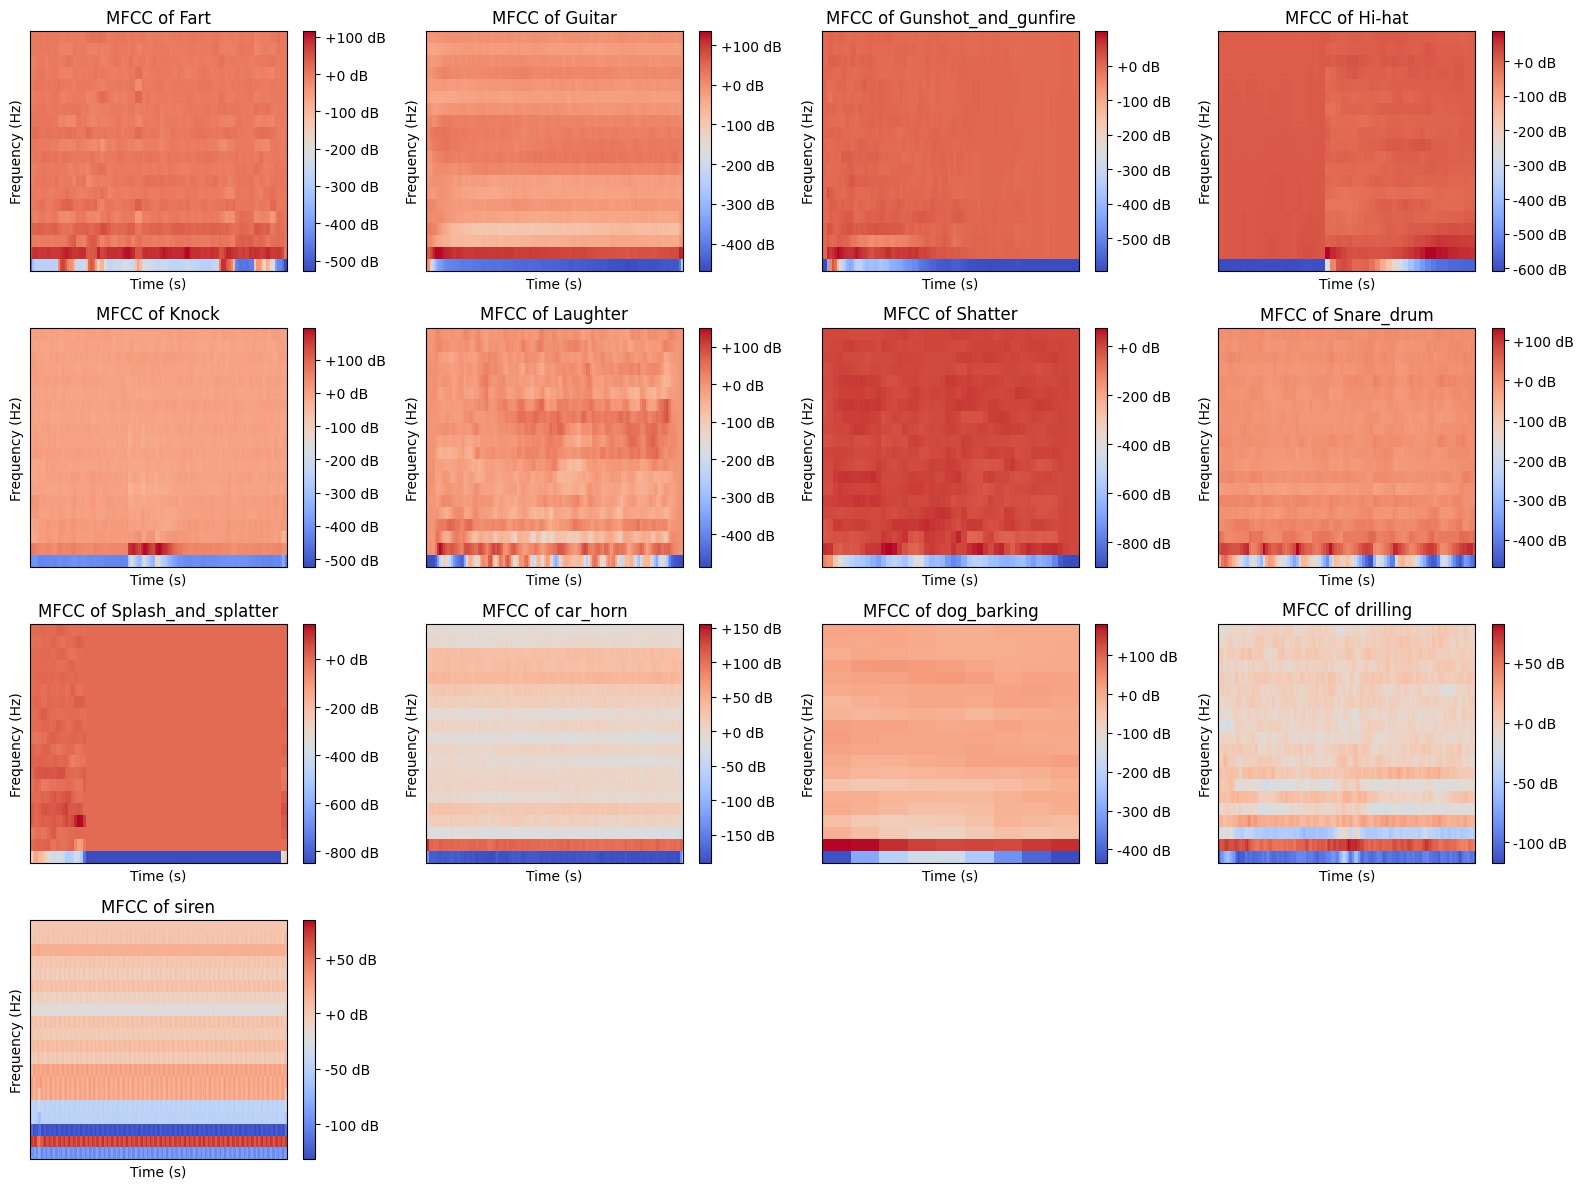

In [7]:
one_per_class = train_df.groupby('Class')['Name'].sample(n=1, random_state=42)

fig, axes = plt.subplots(4,4, figsize=(16,12))
axes = axes.flatten()

for i, name in enumerate(one_per_class):
    file_path = f'train/{name}'
    audio, sr = rs.load(file_path)
    mfcc = rs.feature.mfcc(y=audio, sr=sr)
    img = rs.display.specshow(mfcc, ax=axes[i])
    plt.colorbar(img, ax=axes[i], format='%+2.0f dB')
    class_label = train_df[train_df['Name'] == name]['Class'].iloc[0]
    axes[i].set_title(f'MFCC of {class_label}')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Frequency (Hz)')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

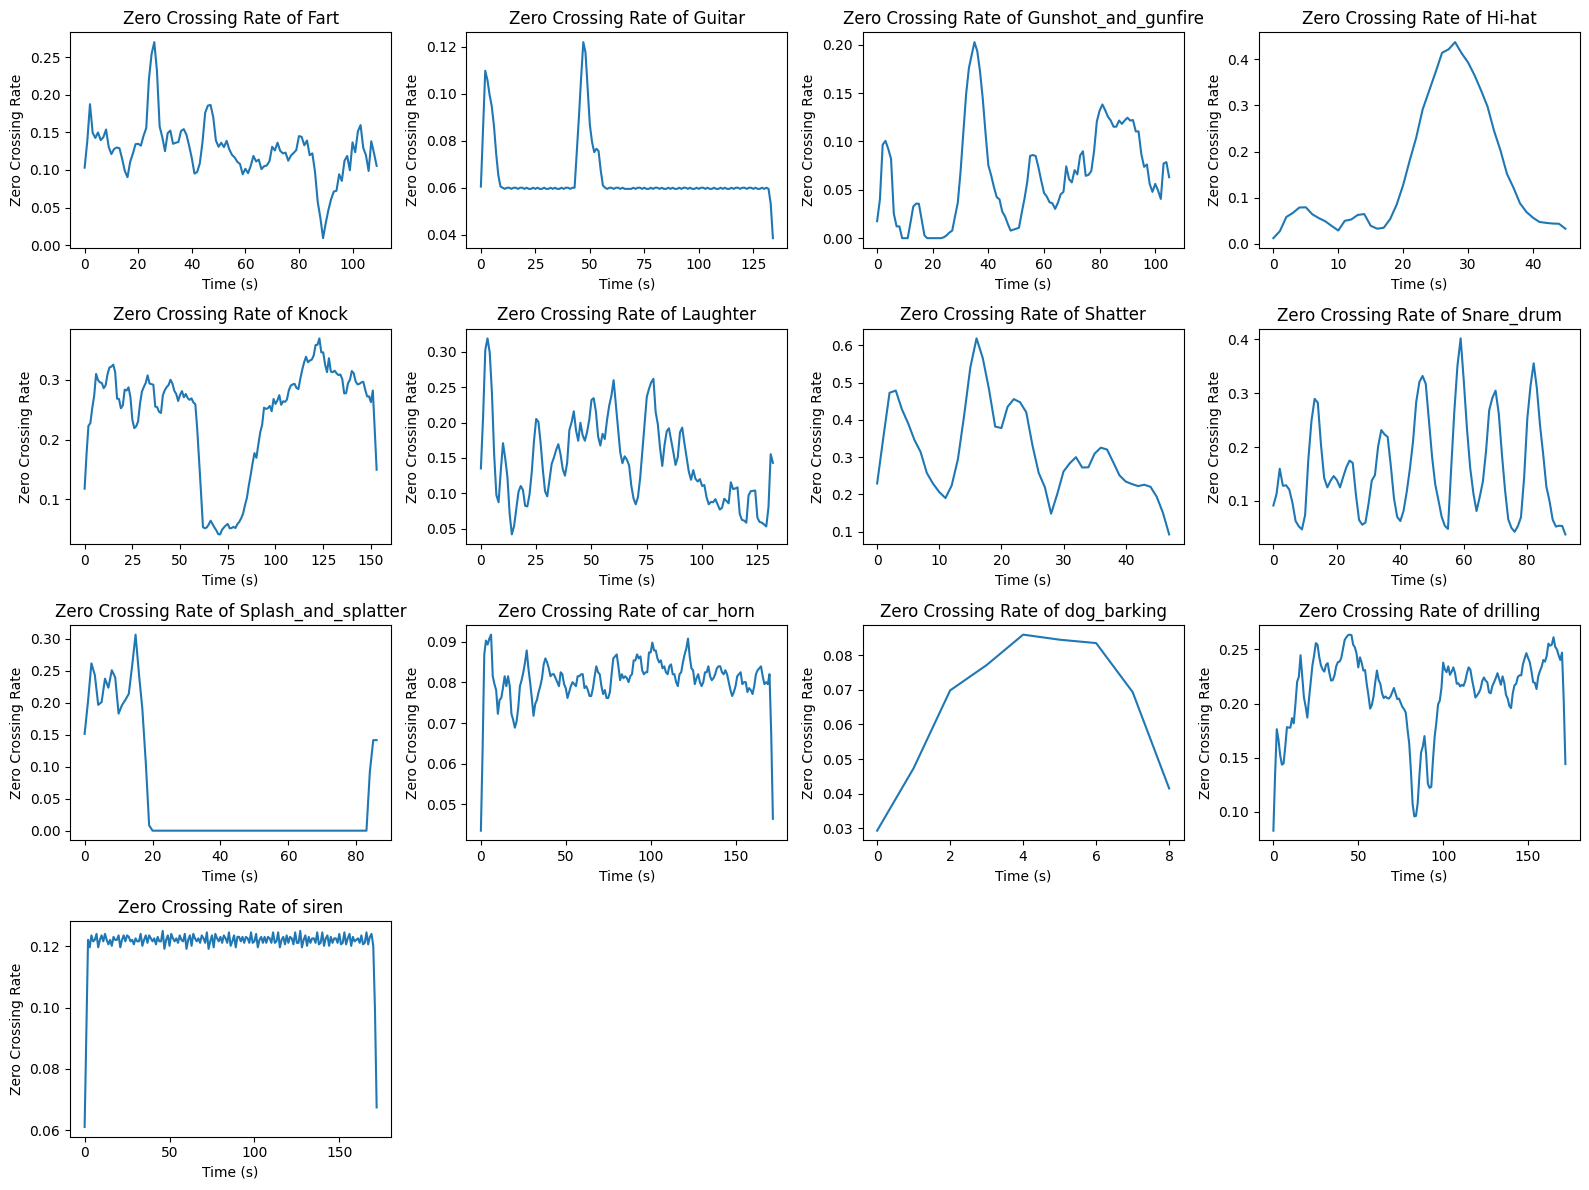

In [15]:
one_per_class = train_df.groupby('Class')['Name'].sample(n=1, random_state=42)

fig, axes = plt.subplots(4,4, figsize=(16,12))
axes = axes.flatten()

for i, name in enumerate(one_per_class):
    file_path = f'train/{name}'
    audio, sr = rs.load(file_path)
    zcr = rs.feature.zero_crossing_rate(audio)
    axes[i].plot(zcr[0])
    class_label = train_df[train_df['Name'] == name]['Class'].iloc[0]
    axes[i].set_title(f'Zero Crossing Rate of {class_label}')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Zero Crossing Rate')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

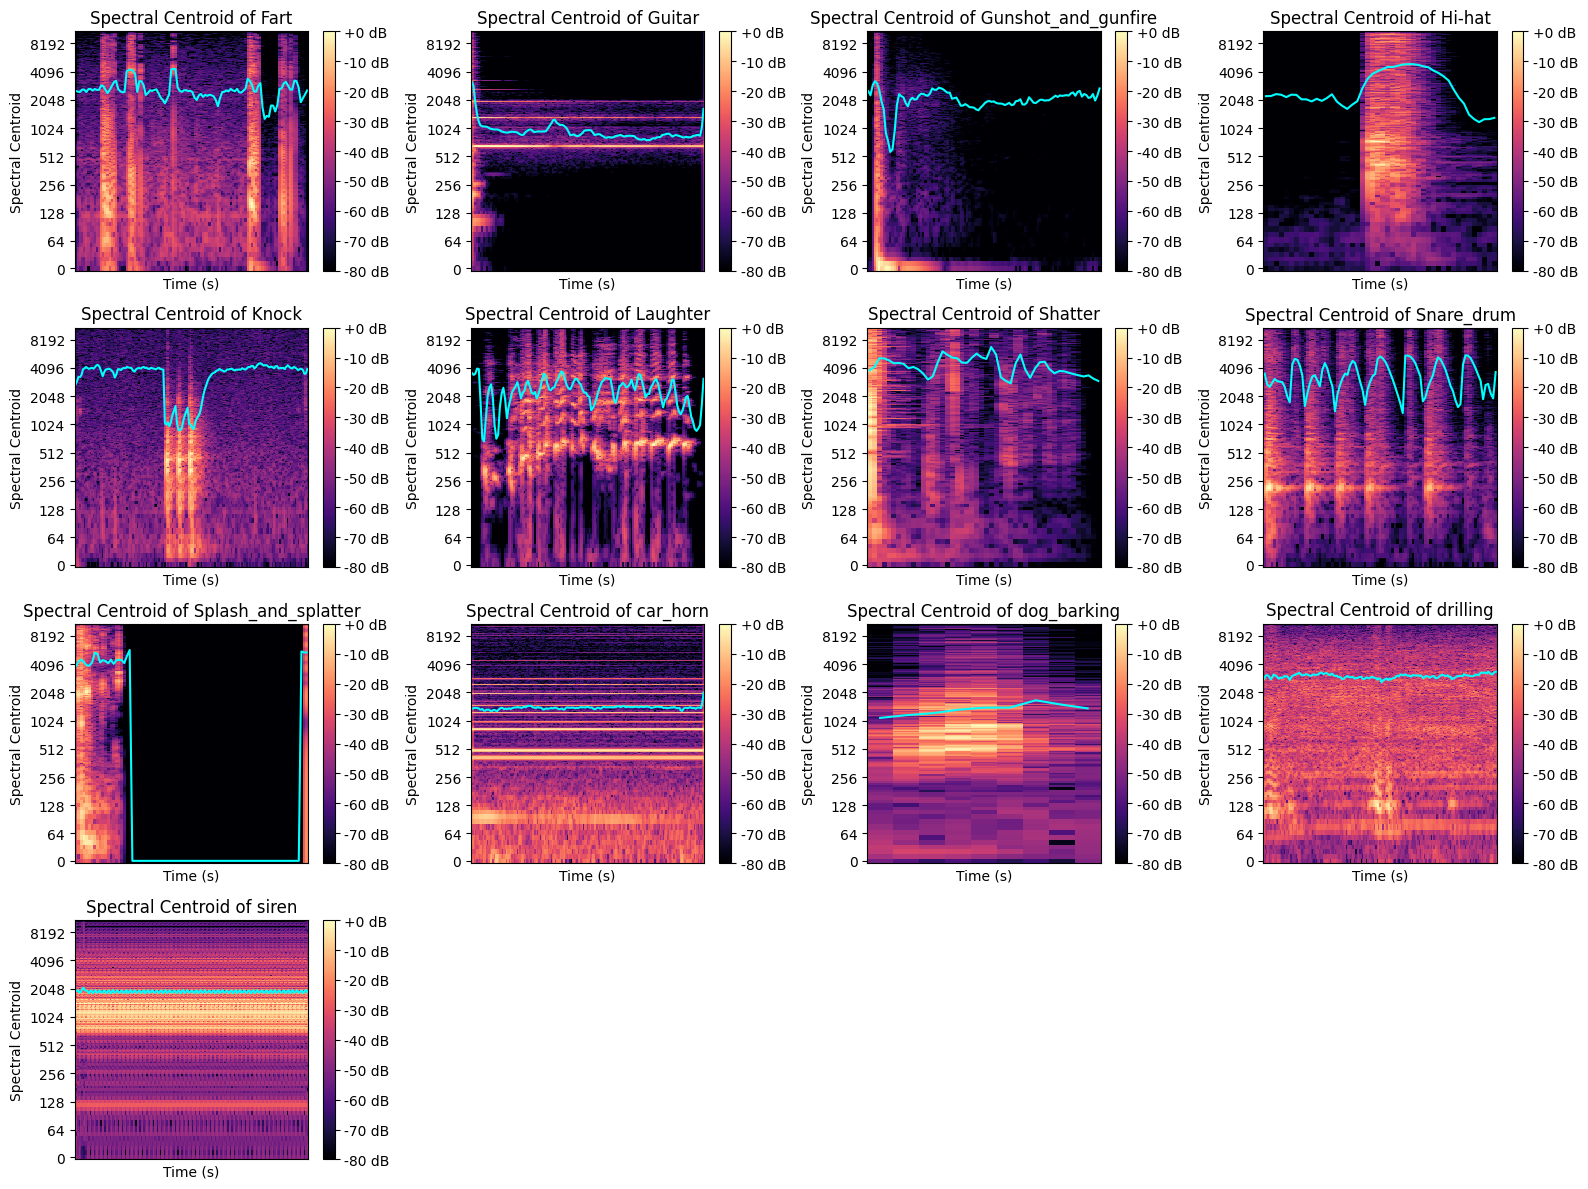

In [22]:
one_per_class = train_df.groupby('Class')['Name'].sample(n=1, random_state=42)

fig, axes = plt.subplots(4,4, figsize=(16,12))
axes = axes.flatten()

for i, name in enumerate(one_per_class):
    file_path = f'train/{name}'
    audio, sr = rs.load(file_path)
    zcr = rs.feature.spectral_centroid(y=audio, sr=sr)
    rs.display.specshow(rs.amplitude_to_db(rs.magphase(rs.stft(audio))[0], ref=np.max), y_axis='log', ax=axes[i])
    axes[i].plot(zcr[0], color='cyan')
    class_label = train_df[train_df['Name'] == name]['Class'].iloc[0]
    plt.colorbar(axes[i].collections[0], ax=axes[i], format='%+2.0f dB')
    axes[i].set_title(f'Spectral Centroid of {class_label}')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Spectral Centroid')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

### Feature Extraction

In [ ]:
features = []
labels = []

def parser_mfcc(df , path):
    for i in tqdm(range(df.shape[0])):
        try:
            file_name = f'{path}/{df["Name"][i]}'
            data, sr = librosa.load(file_name) 
            n_fft = min(2048, len(data))

            #mfcc
            mfcc = librosa.feature.mfcc(y=data, sr=sr, n_fft=n_fft)
            mfcc_mean = np.mean(mfcc, axis=1)  
            mfcc_std = np.std(mfcc, axis=1)
            mfcc_max = np.max(mfcc, axis=1)
            mfcc_min = np.min(mfcc, axis=1)    

            # Zero crossing rate
            zcra = librosa.feature.zero_crossing_rate(data)
            zcr = np.mean(zcra)
            zcr_std = np.std(zcra)
            zcr_min = np.min(zcra)
            zcr_max = np.max(zcra)

            # Spectral Centroid
            spectral_cent = librosa.feature.spectral_centroid(y=data, sr=sr)
            spectral_centroid = np.mean(spectral_cent) 
            spectral_centroid_std = np.std(spectral_cent)
            spectral_cent_min = np.min(spectral_cent)
            spectral_cent_max = np.max(spectral_cent)
            
            #Spectral Bandwidth
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sr)
            spectral_bandwidth_mean = np.mean(spectral_bandwidth)
            spectral_bandwidth_std = np.std(spectral_bandwidth)
            spectral_bandwidth_min = np.min(spectral_bandwidth)
            spectral_bandwidth_max = np.max(spectral_bandwidth)

            features.append(np.concatenate([mfcc_mean, mfcc_std,mfcc_min, mfcc_max, [zcr , zcr_std, zcr_min, zcr_max], [spectral_centroid, spectral_centroid_std, spectral_cent_min, spectral_cent_max], [spectral_bandwidth_mean, spectral_bandwidth_std, spectral_bandwidth_min, spectral_bandwidth_max]]))
            labels.append(df["ClassId"][i])
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
            continue

    return features, labels


In [40]:
x_train, y_train = parser_mfcc(train_df , 'train')
x_test , y_test = parser_mfcc(test_df , 'val')

 28%|██▊       | 1371/4861 [00:46<01:57, 29.74it/s]d:\KMITL\2.2\AI-tech\Beeing\Project\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
 29%|██▉       | 1402/4861 [00:47<01:37, 35.44it/s]d:\KMITL\2.2\AI-tech\Beeing\Project\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
 39%|███▉      | 1911/4861 [00:58<00:56, 52.50it/s]C:\Users\gamin\AppData\Local\Temp\ipykernel_18836\3532713645.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sr = librosa.load(file_name)
d:\KMITL\2.2\AI-tech\Beeing\Project\.venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 84%|████████▍ | 4105/4861 [01:57<00:18, 41

Error loading train/Laughter/Laughter_284.flac: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.


 28%|██▊       | 343/1209 [00:11<00:25, 34.18it/s]d:\KMITL\2.2\AI-tech\Beeing\Project\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
100%|██████████| 1209/1209 [00:35<00:00, 33.74it/s]


### Building Model

In [41]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(f""" 
Before Scaling:
Mean: {np.mean(x_train)}
Std: {np.std(x_train)}
Min: {np.min(x_train)}
Max: {np.max(x_train)}

After Scaling:
Mean: {np.mean(x_train_scaled)}
Std: {np.std(x_train_scaled)}
Min: {np.min(x_train_scaled)}
Max: {np.max(x_train_scaled)}
""")

 
Before Scaling:
Mean: 154.12281788017467
Std: 661.3186551668529
Min: -1124.3209228515625
Max: 10424.936584461331

After Scaling:
Mean: 0.4015998350834553
Std: 0.20969738295000584
Min: 0.0
Max: 1.0000000000000002



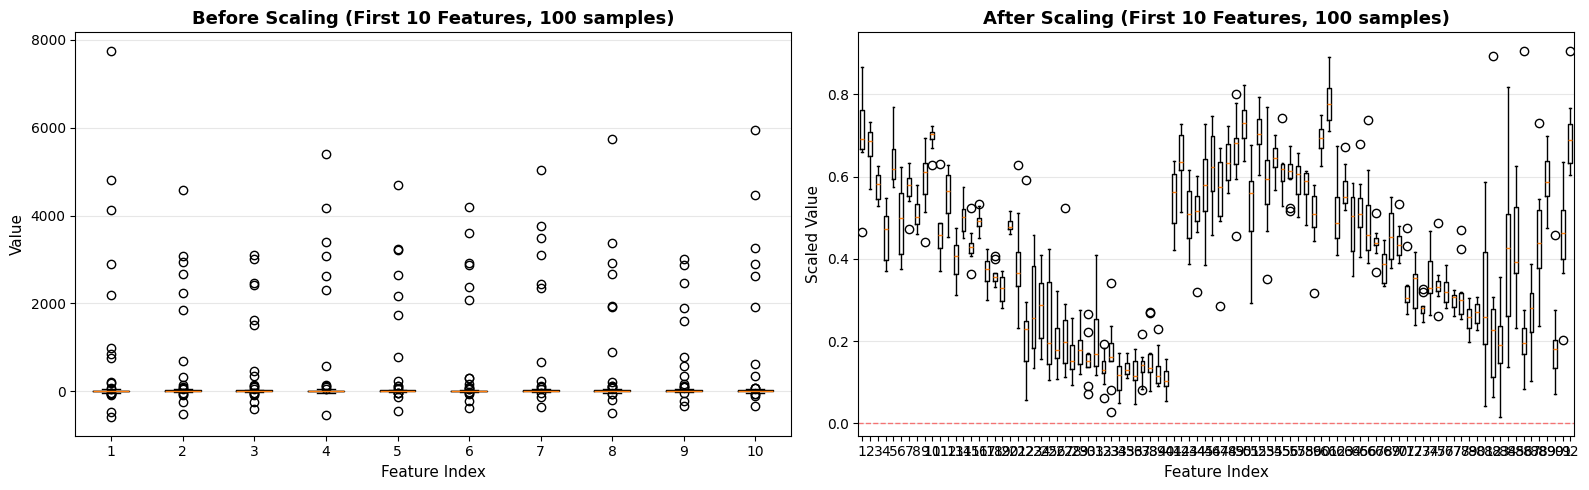

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sample_features = x_train[:100][:10]
axes[0].boxplot(sample_features)
axes[0].set_title('Before Scaling (First 10 Features, 100 samples)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Feature Index', fontsize=11)
axes[0].set_ylabel('Value', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

sample_features_scaled = x_train_scaled[:100][:10]
axes[1].boxplot(sample_features_scaled)
axes[1].set_title('After Scaling (First 10 Features, 100 samples)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Feature Index', fontsize=11)
axes[1].set_ylabel('Scaled Value', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=1, alpha=0.5, label='Mean=0')

plt.tight_layout()
plt.show()


In [43]:
model = GaussianNB()
model.fit(x_train , y_train)
y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.56      0.59       363
           1       0.63      0.77      0.70       265
           2       0.94      0.71      0.81       213
           3       0.94      0.61      0.74       700
           4       0.55      0.84      0.67       429
           5       0.84      0.85      0.84       561
           6       0.47      0.53      0.50       217
           7       0.50      0.84      0.63       209
           8       0.81      0.70      0.75       684
           9       0.66      0.73      0.70       560
          10       0.71      0.52      0.60       800
          11       0.49      0.62      0.55       368
          12       0.73      0.77      0.75       700

    accuracy                           0.69      6069
   macro avg       0.68      0.70      0.68      6069
weighted avg       0.72      0.69      0.69      6069



In [44]:
from naivebayes import NaiveBayes

own_model = NaiveBayes()

own_model.fit(x_train_scaled, y_train)

own_prb = own_model.classify(x_test_scaled)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.63      0.56      0.59       363
           1       0.63      0.77      0.70       265
           2       0.94      0.71      0.81       213
           3       0.94      0.61      0.74       700
           4       0.55      0.84      0.67       429
           5       0.84      0.85      0.84       561
           6       0.47      0.53      0.50       217
           7       0.50      0.84      0.63       209
           8       0.81      0.70      0.75       684
           9       0.66      0.73      0.70       560
          10       0.71      0.52      0.60       800
          11       0.49      0.62      0.55       368
          12       0.73      0.77      0.75       700

    accuracy                           0.69      6069
   macro avg       0.68      0.70      0.68      6069
weighted avg       0.72      0.69      0.69      6069



In [66]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)
y_pred_rf = model.predict(x_test)

print(classification_report(y_test, y_pred_rf))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00       363
           1       1.00      1.00      1.00       265
           2       0.97      0.98      0.97       213
           3       1.00      1.00      1.00       700
           4       1.00      1.00      1.00       429
           5       0.99      0.99      0.99       561
           6       1.00      1.00      1.00       217
           7       1.00      1.00      1.00       209
           8       1.00      1.00      1.00       684
           9       1.00      1.00      1.00       560
          10       1.00      1.00      1.00       800
          11       1.00      1.00      1.00       368
          12       1.00      1.00      1.00       700

    accuracy                           1.00      6069
   macro avg       1.00      1.00      1.00      6069
weighted avg       1.00      1.00      1.00      6069

